Question 1:
How has the public perception of anti-vaccine conspiracy via YouTube changed during the last five years?

In [ ]:
import sys

!{sys.executable} -m pip install spacy

!{sys.executable} -m spacy download en_core_web_sm

!{sys.executable} -m pip install --upgrade scipy --no-cache-dir

!{sys.executable} -m pip uninstall numpy -y
!{sys.executable} -m pip install numpy==1.24.4 --no-cache-dir

!{sys.executable} pip install pandas==1.5.3 --no-cache-dir


In [ ]:
import numpy as np
print(np.__version__)

In [ ]:
import pandas as pd
import json
from collections import Counter

import ast
from keybert import KeyBERT
import re


data = pd.read_csv('one.csv')

# The next line cleans the data by removing duplicate lines.
data.drop_duplicates(inplace = True)

data['Published At'] = pd.to_datetime(data['Published At'])

# # These are the time periods for the comparison of the top keywords.
time_periods = [
    ('2020', '2020-01-01', '2020-12-31'),
    ('2021', '2021-01-01', '2021-12-31'),
    ('2022', '2022-01-01', '2022-12-31'),
    ('2023', '2023-01-01', '2023-12-31'),
    ('2024', '2024-01-01', '2024-12-31'),
    ('2025', '2025-01-01', '2025-12-31'),
]

result = {}

def extract_keywords(data):
    model = KeyBERT()
    keywords_list = []

    for item in data:
        text = str(item)
        # kw_single extracts single-word keywords.
        kw_single = model.extract_keywords(text, keyphrase_ngram_range=(1,1))
        keywords_list.extend(kw_single)

    ignore_words = []

    flattened_keywords = [kw for kw, score in keywords_list if kw.lower() not in ignore_words]

    # keywords_df creates a Counter which counts how often words occurs in the texts.
    keywords_df = pd.DataFrame(Counter(flattened_keywords).items(), columns=["words", "numbers"])
    frequent_words = keywords_df.loc[keywords_df['numbers']].sort_values(by='numbers', ascending=False)
    return frequent_words

for name, start, end in time_periods:
    filter = (data['Published At'] >= start) & (data['Published At'] <= end)
    filtered = data[filter]

    frequent_words = extract_keywords(filtered['TOP 10 comments'].astype(str).tolist())
    result[name] = {
            'keywords': frequent_words.head(15).to_dict(orient="records")  # The 15 most used words are added to the result.
        }

with open('answer_one.json', 'w', encoding='utf-8') as file:
    json.dump(result, file, indent=2)

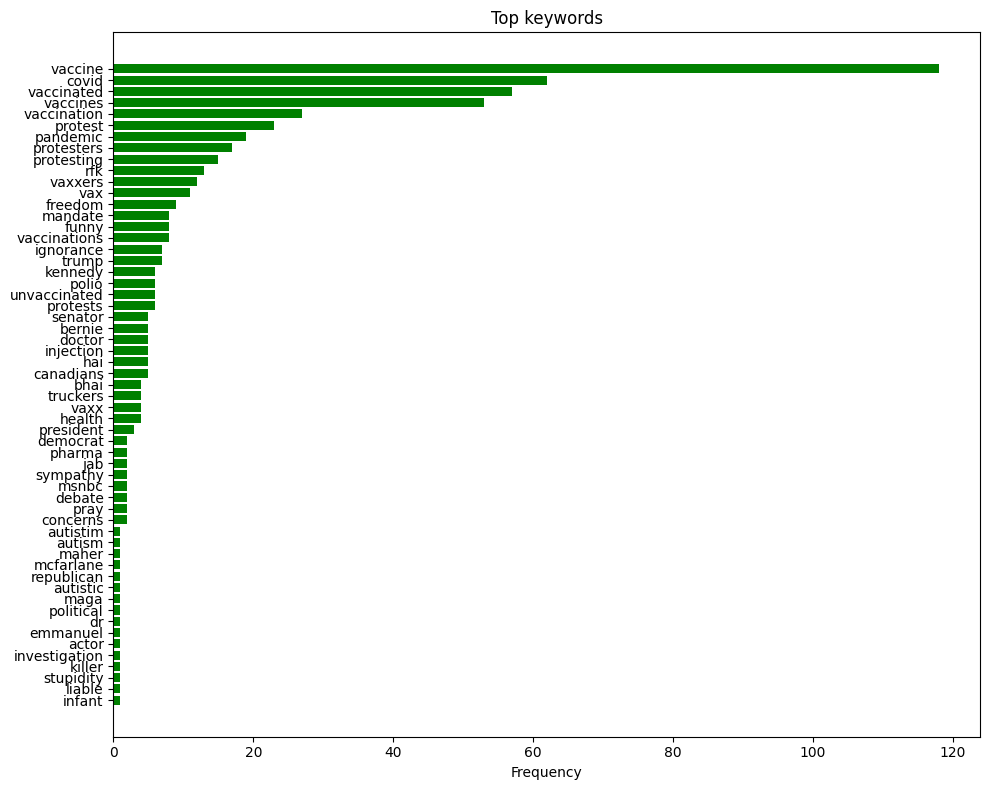

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

import json
from collections import defaultdict

with open('answer_one.json', 'r', encoding='utf-8') as file:
    keywords = json.load(file)

frequencies_all_years = defaultdict(int)

for year, content in keywords.items():
    for kw in content['keywords']:
        keyword = kw["words"]
        frequency = int(kw["numbers"])  
        frequencies_all_years[keyword] += frequency

data = pd.DataFrame(frequencies_all_years.items(), columns=['Keyword', 'Frequency'])
data = data.sort_values(by='Frequency', ascending=True)

# The visualizations combines all most used words from 2020 until 2025 in a bar chart.

plt.figure(figsize=(10,8))
plt.barh(data['Keyword'], data['Frequency'], color='green')
plt.xlabel('Frequency')
plt.title(f'Top keywords')
plt.tight_layout()
plt.show()



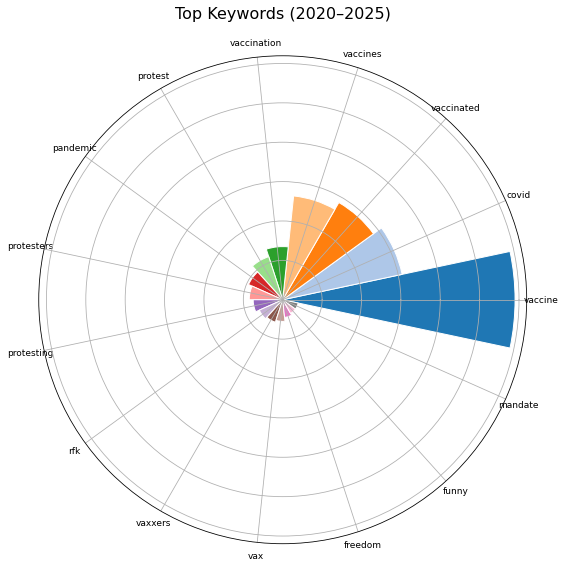

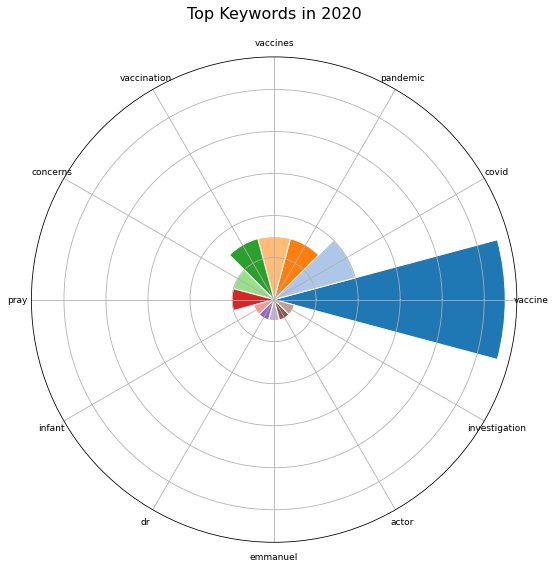

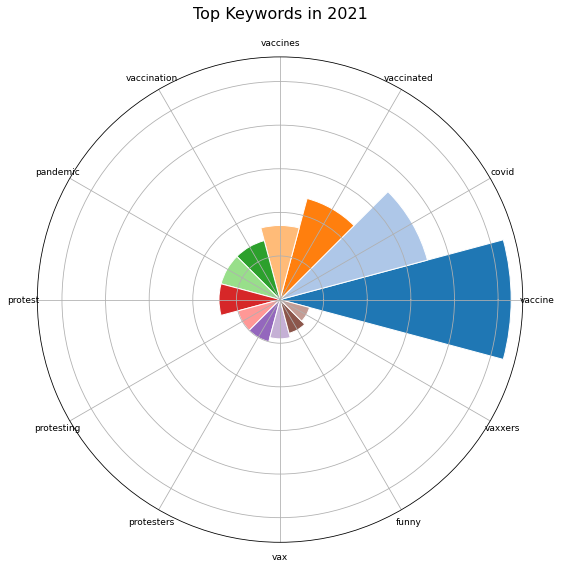

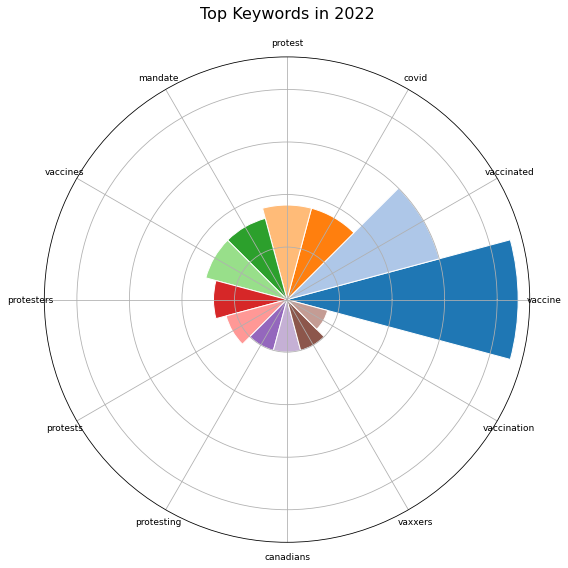

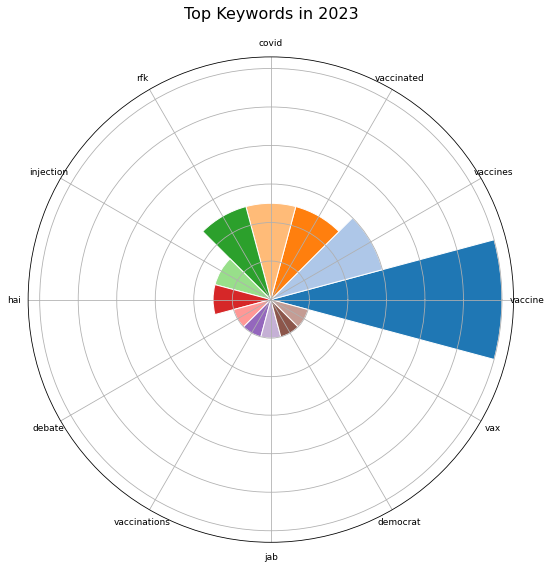

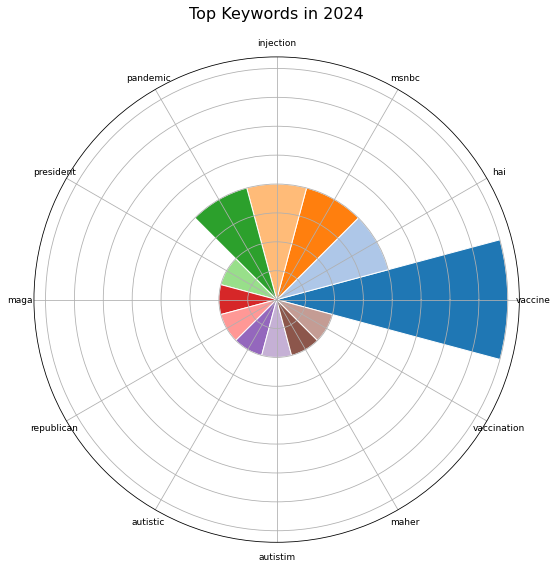

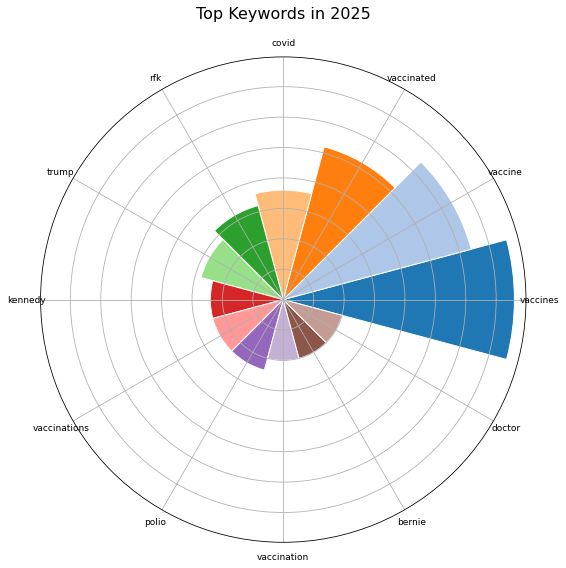

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import json
from collections import defaultdict

# JSON laden
with open('answer_one.json', 'r', encoding='utf-8') as file:
    data = json.load(file)

# Farben definieren (oder aus colormap nehmen)
def get_colors(n):
    cmap = plt.cm.tab20  # gute Mischung an Farben
    return [cmap(i) for i in range(n)]

# Funktion für Nightingale / Coxcomb Chart
def draw_nightingale_chart(labels, values, title):
    num_vars = len(labels)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False)
    radii = values

    # Für Ring schließen
    angles = np.concatenate((angles, [angles[0]]))
    radii = np.concatenate((radii, [radii[0]]))

    colors = get_colors(num_vars)

    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

    bars = ax.bar(
        angles[:-1],             # Winkel
        values,                  # Höhe (Radius)
        width=2 * np.pi / num_vars,  # Alle Segmente gleich breit
        bottom=0,                # Beginnt beim Mittelpunkt
        color=colors,
        edgecolor='white',
        linewidth=1
    )

    # Labels außen setzen
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, fontsize=9)

    # Kein Radius-Grid
    ax.set_yticklabels([])
    ax.set_title(title, fontsize=16, pad=20)

    plt.tight_layout()
    plt.show()

# 🔹 Kombiniertes Diagramm (Top 15)
combined_counts = defaultdict(int)
for year_data in data.values():
    for keyword in year_data['keywords']:
        combined_counts[keyword['words']] += keyword['numbers']

combined_sorted = sorted(combined_counts.items(), key=lambda x: x[1], reverse=True)[:15]
labels_combined, values_combined = zip(*combined_sorted)
draw_nightingale_chart(list(labels_combined), list(values_combined), "Top Keywords (2020–2025)")

# 🔹 Einzeljahre
for year, year_data in data.items():
    keywords = year_data['keywords']
    sorted_keywords = sorted(keywords, key=lambda x: x['numbers'], reverse=True)[:12]  # z.B. Top 12
    labels = [k['words'] for k in sorted_keywords]
    values = [k['numbers'] for k in sorted_keywords]
    draw_nightingale_chart(labels, values, f"Top Keywords in {year}")